In [4]:
import numpy as np
import copy as cp
import pylab as pl

In [5]:
####################################################################################################################################################
####################################################################################################################################################
####################################################################################################################################################

#																	ENVIRONMENTS

####################################################################################################################################################
####################################################################################################################################################
####################################################################################################################################################




# A simple riverswim implementation with chosen number of state 'nS' chosen in input.
# We arbitrarily chose the action '0' = 'go to the left' thus '1' = 'go to the right'.
# Finally the state '0' is the leftmost, 'nS - 1' is the rightmost.
class riverswim():

	def __init__(self, nS):
		self.nS = nS
		self.nA = 2

		# We build the transitions matrix P, and its associated support lists.
		self.P = np.zeros((nS, 2, nS))
		self.support = [[[] for _ in range(self.nA)] for _ in range(self.nS)]
		for s in range(nS):
			if s == 0:
				self.P[s, 0, s] = 0.95
				self.P[s, 0, s + 1] = 0.05
				self.P[s, 1, s] = 0.6
				self.P[s, 1, s + 1] = 0.4
				self.support[s][0] += [0]
				self.support[s][1] += [0, 1]
			elif s == nS - 1:
				self.P[s, 0, s - 1] = 1
				self.P[s, 1, s] = 0.6
				self.P[s, 1, s - 1] = 0.4
				self.support[s][0] += [s - 1]
				self.support[s][1] += [s - 1, s]
			else:
				self.P[s, 0, s - 1] = 1
				self.P[s, 1, s] = 0.55
				self.P[s, 1, s + 1] = 0.4
				self.P[s, 1, s - 1] = 0.05
				self.support[s][0] += [s - 1]
				self.support[s][1] += [s - 1, s, s + 1]
		
		# We build the reward matrix R.
		self.R = np.zeros((nS, 2))
		self.R[0, 0] = 0.05
		self.R[nS - 1, 1] = 1

		# We (arbitrarily) set the initial state in the leftmost position.
		self.s = 0

	# To reset the environment in initial settings.
	def reset(self):
		self.s = np.random.randint(self.nS)
		return self.s

	# Perform a step in the environment for a given action. Return a couple state, reward (s_t, r_t).
	def step(self, action):
		new_s = np.random.choice(np.arange(self.nS), p=self.P[self.s, action])
		reward = self.R[self.s, action]
		self.s = new_s
		return new_s, reward

In [6]:
class MBIE():
	def __init__(self, nS, nA, gamma, epsilon = 0.1, delta = 0.05, m = 100):
		self.nS = nS
		self.nA = nA
		self.gamma = gamma
		self.epsilon = epsilon
		self.m = m # Max for the number of sample used in estimate as introduced originally in the paper.
		self.delta = delta / (2 * nS * nA * m)# As used in proof of lemma 5 in the original paper.
		self.s = None

		# The "counter" variables:
		self.Nsa = np.zeros((self.nS, self.nA), dtype=int) # Number of occurences of (s, a).
		self.Nsas = np.zeros((self.nS, self.nA, self.nS), dtype=int) # Number of occureces of (s, a, s').
		self.Rsa = np.zeros((self.nS, self.nA)) # Cumulated reward observed for (s, a).

		# The "estimates" variables:
		self.hatP = np.zeros((self.nS, self.nA, self.nS)) # Estimate of the transition matrix.
		self.hatR = np.zeros((self.nS, self.nA))
		
		# Confidence intervals:
		self.confR = np.zeros((self.nS, self.nA))
		self.confP = np.zeros((self.nS, self.nA))
		
	
	# Update the confidence intervals.
	def confidence(self):
		for s in range(self.nS):
			for a in range(self.nA):
				self.confP[s, a] = np.sqrt((2*(np.log(2**self.nS - 2) - np.log(self.delta)) / max((1, self.Nsa[s, a]))))
				self.confR[s, a] = np.sqrt(np.log(2/self.delta)/(2 * max((1, self.Nsa[s, a]))))

	# Reset the model.
	def reset(self, init):
		# The "counter" variables:
		self.Nsa = np.zeros((self.nS, self.nA), dtype=int) # Number of occurences of (s, a).
		self.Nsas = np.zeros((self.nS, self.nA, self.nS), dtype=int) # Number of occureces of (s, a, s').
		self.Rsa = np.zeros((self.nS, self.nA)) # Cumulated reward observed for (s, a).

		# The "estimates" variables:
		self.hatP = np.zeros((self.nS, self.nA, self.nS)) # Estimate of the transition matrix
		self.hatR = np.zeros((self.nS, self.nA))
		
		# Confidence intervals:
		self.confR = np.zeros((self.nS, self.nA))
		self.confP = np.zeros((self.nS, self.nA))

		# Set the initial state and last action:
		self.s = init
		self.last_action = -1


	# Computing the maximum proba in the Extended Value Iteration for given state s and action a.
	# From UCRL2 jacksh et al. 2010.
	def max_proba(self, sorted_indices, s, a):
		min1 = min([1, self.hatP[s, a, sorted_indices[-1]] + (self.confP[s, a] / 2)])
		max_p = np.zeros(self.nS)
		if min1 == 1:
			max_p[sorted_indices[-1]] = 1
		else:
			max_p = cp.deepcopy(self.hatP[s, a])
			max_p[sorted_indices[-1]] += self.confP[s, a] / 2
			l = 0
			while sum(max_p) > 1:
				max_p[sorted_indices[l]] = max([0, 1 - sum(max_p) + max_p[sorted_indices[l]]])
				l += 1
		return max_p


	# The Extended Value Iteration, perform an optimisitc VI over a set of MDP.
	def EVI(self, max_iter = 2*10**2, epsilon = 10**(-1)):
		niter = 0
		gamma = self.gamma
		sorted_indices = np.arange(self.nS)

		# The variable containing the optimistic policy estimate at the current iteration.
		policy = np.zeros(self.nS, dtype=int)

		# Initialise the value and epsilon as proposed in the course.
		V0 = np.array([1/(1 - gamma) for _ in range(self.nS)])
		V1 = np.zeros(self.nS)
		epsilon = epsilon * (1 - gamma) / (2 * gamma)

		# The main loop of the Value Iteration algorithm.
		while True:
			niter += 1
			for s in range(self.nS):
				for a in range(self.nA):
					maxp = self.max_proba(sorted_indices, s, a)
					temp = self.hatR[s, a] + self.confR[s, a] + gamma * sum([V * p for (V, p) in zip(V0, maxp)])
					if (a == 0) or (temp > V1[s]):
						V1[s] = temp
						policy[s] = a

			# Testing the stopping criterion (+1 abitrary stop when 'max_iter' is reached).
			if np.linalg.norm(V1 - V0) < self.epsilon:
				return policy
			else:
				V0 = V1
				V1 = np.array([1/(1 - gamma) for _ in range(self.nS)])
				sorted_indices = np.argsort(V0)
			if niter > max_iter:
				print("No convergence in EVI after: ", max_iter, " steps!")
				return policy


	def play(self, state, reward):
		if self.last_action >= 0: # Update if not first action.
			self.Nsas[self.s, self.last_action, state] += 1
			self.Rsa[self.s, self.last_action] += reward

		# Update estimates and confidence intervals.
		self.confidence()
		for s in range(self.nS):
			for a in range(self.nA):
				self.hatR[s, a] = self.Rsa[s, a] / max((1, self.Nsa[s, a]))
				for ss in range (self.nS):
					self.hatP[s, a, ss] = self.Nsas[s, a, ss] / max((1, self.Nsa[s, a]))
		
		# Run EVI and get new optimisitc greedy policy.
		policy = self.EVI()
		action = policy[state]

		# Update the variables:
		self.Nsa[state, action] += 1
		self.s = state
		self.last_action = action

		return action, policy

In [10]:
def VI(env, gamma = 0.9, max_iter = 10**3, epsilon = 10**(-2)):

	# The variable containing the optimal policy estimate at the current iteration.
	policy = np.zeros(env.nS, dtype=int)
	niter = 0

	# Initialise the value and epsilon as proposed in the course.
	V0 = np.array([1/(1 - gamma) for _ in range(env.nS)])
	V1 = np.zeros(env.nS)
	epsilon = epsilon * (1 - gamma) / (2 * gamma)

	# The main loop of the Value Iteration algorithm.
	while True:
		niter += 1
		for s in range(env.nS):
			for a in range(env.nA):
				temp = env.R[s, a] + gamma * sum([V * p for (V, p) in zip(V0, env.P[s, a])])
				if (a == 0) or (temp > V1[s]):
					V1[s] = temp
					policy[s] = a
		
		# Testing the stopping criterion (+1 abitrary stop when 'max_iter' is reached).
		if np.linalg.norm(V1 - V0) < epsilon:
			return niter, V0, policy
		else:
			V0 = V1
			V1 = np.array([1/(1 - gamma) for _ in range(env.nS)])
		if niter > max_iter:
			print("No convergence in VI after: ", max_iter, " steps!")
			return niter, V0, policy

Initialisation of V^*...
Running experiments...
Plotting...


OSError: [Errno 22] Invalid argument: 'Figure_MBIE_V^*(s_init)_discounted_reward.pdf'

<Figure size 432x288 with 0 Axes>

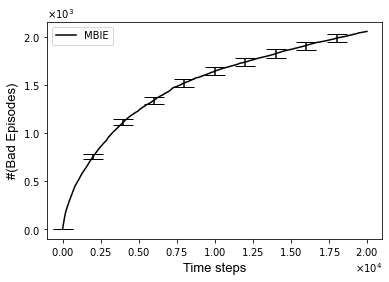

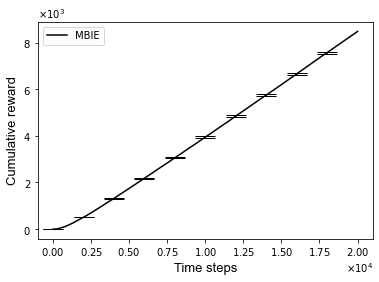

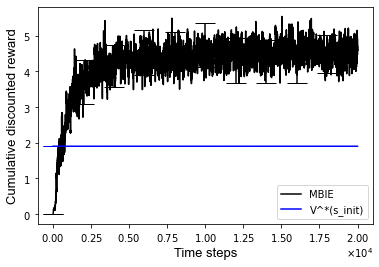

In [13]:
# Map a policy to a unique int in 2**|S|.
# Only for environemnts with 2 actions!
def map_pi(pi):
	S = len(pi)
	res = 0
	for i in range(S):
		res += 2**i * pi[-i - 1]
	return res

# Map an int in 2**|S| into a unique policy.
# Take an int and |S| as input.
def rev_map_pi(i, S):
	pi = [int(x) for x in bin(i)[2:]]
	temp = [0 for _ in range(S - len(pi))]
	return temp + pi

# Return a list of all V^pi, mapped with the functions map_pi and rev_map_pi. Also return V^*.
# Take an environment and gamma as input.
def make_V_list(env, gamma):
	_, _, pi_star = VI(env, gamma) # We get the optimal policy.
	V = []
	for i in range(2**env.nS):
		pi = rev_map_pi(i, env.nS)
		P_pi = np.array([env.P[s, pi[s]] for s in range(env.nS)])
		R_pi = [env.R[s, pi[s]] for s in range(env.nS)]
		V.append(np.dot(np.linalg.inv(np.identity(env.nS) - np.multiply(P_pi, gamma)), np.array(R_pi)))
	V_star = V[map_pi(pi_star)]
	return V, V_star




# Plotting function.
def plot(data, names, y_label = "#(Bad Episodes)", exp_name = "error"):
	timeHorizon = len(data[0][0])
	colors= ['black', 'blue', 'purple','cyan','yellow', 'orange', 'red']
	nbFigure = pl.gcf().number+1

	# Average the results and plot them.
	avg_data = []
	pl.figure(nbFigure)
	for i in range(len(data)):
		avg_data.append(np.mean(data[i], axis=0))
		pl.plot(avg_data[i], label=names[i], color=colors[i%len(colors)])

	# Compute standard deviantion and plot the associated error bars.
	step=(timeHorizon//10)
	for i in range(len(data)):
		std_data = 1.96 * np.std(data[i], axis=0) / np.sqrt(len(data[i]))
		pl.errorbar(np.arange(0,timeHorizon,step), avg_data[i][0:timeHorizon:step], std_data[0:timeHorizon:step], color=colors[i%len(colors)], linestyle='None', capsize=10)
	
	# Label and format the plot.
	pl.legend()
	pl.xlabel("Time steps", fontsize=13, fontname = "Arial")
	pl.ylabel(y_label, fontsize=13, fontname = "Arial")
	pl.ticklabel_format(axis='both', useMathText = True, useOffset = True, style='sci', scilimits=(0, 0))

	# Uncomment below to get log scale y-axis.
	#pl.yscale('log')
	#pl.ylim(1)

	# Save the plot.
	name = ""
	for n  in names:
		name += n + "_"
	pl.savefig("Figure_" + name + exp_name + '.pdf')





# Test function, plotting the cumulative nb of episode where |V* - V^pi_t| > epsilon.
def run():
	# Set the environment:
	nS = 5
	env = riverswim(nS)
	gamma = 0.90
	epsilon = 0.1

	# Set the time horizon:
	T = 2 * 10**4
	nb_Replicates = 35

	# Set the learning agents:
	MB = MBIE(nS, 2, gamma)

	# Set the variables used for plotting.
	cumerror_MB = [[0] for _ in range(nb_Replicates)]
	cumreward_MB = [[0] for _ in range(nb_Replicates)]
	cumdiscountedreward_MB = [[0] for _ in range(nb_Replicates)]
	

	print("Initialisation of V^*...")
	V, V_star = make_V_list(env, gamma)

	# Run the experiments:
	print("Running experiments...")
	for i in range(nb_Replicates):

		# Running an instance of MBIE:
		env.reset()
		MB.reset(env.s)
		reward = 0
		new_s = env.s
		for t in range(T - 1):
			action, policy = MB.play(new_s, reward)
			temp = V[map_pi(policy)]
			cumerror_MB[i].append(cumerror_MB[i][-1]+(int(temp[new_s]<= V_star[new_s] - epsilon)))
			new_s, reward = env.step(action)
			cumreward_MB[i].append(cumreward_MB[i][-1]+reward)
			cumdiscountedreward_MB[i].append(gamma*cumdiscountedreward_MB[i][-1]+reward)
	
	# Plot and finish.
	print("Plotting...")
	V_star_init = [V_star[0] for _ in range(T)] # A list containing V^*(s_init) T times, used to plot this value.
	plot([cumerror_MB], ["MBIE"])
	plot([cumreward_MB], ["MBIE"], y_label = "Cumulative reward", exp_name = "reward")
	plot([cumdiscountedreward_MB, [V_star_init]], ["MBIE", "V^*(s_init)"], y_label = "Cumulative discounted reward", exp_name = "discounted_reward")
	print('Done!')


run()